# CNN 2D Classifier Training Example

This notebook demonstrates a 5 layered Multisacle CNN with two branches (flux and ivar) trained to classify spectra from single spectra and lensed spectra. In this notebook the classifier assumes we can work in the host rest frame.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

In [1]:
from glob import glob

import pickle 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

In [2]:
mpl.rc('font', size=18)

## Input Spectra

Input DESI spectra generated from the pickle notebook. Then divide them into training and test sets for the classifier.

In [6]:
lens_flux=[]
for i in range(0,19):
    with open('lens_spectra{}.data'.format(i), 'rb') as filehandle:
        # read the data as binary data stream
        items=pickle.load(filehandle)
        for i in items:
            lens_flux.append(i)
lens_ivar=[]
for i in range(0,19):
    with open('lens_spectra{}_ivar.data'.format(i), 'rb') as filehandle:
        # read the data as binary data stream
        items=pickle.load(filehandle)
        for i in items:
            lens_ivar.append(i)

In [7]:
lens_flux=np.asarray(lens_flux)
lens_ivar=np.asarray(lens_ivar)
lens=np.stack((lens_flux, lens_ivar), axis=-1)

In [8]:
lens.shape

(6283, 60, 60, 2)

In [9]:
single_flux=[]
for i in range(0,6):
    with open('single_spectra{}.data'.format(i), 'rb') as filehandle:
        # read the data as binary data stream
        items=pickle.load(filehandle)
        for i in items:
            single_flux.append(i)
single_ivar=[]
for i in range(0,6):
    with open('single_spectra{}_ivar.data'.format(i), 'rb') as filehandle:
        # read the data as binary data stream
        items=pickle.load(filehandle)
        for i in items:
            single_ivar.append(i)

In [12]:
single.shape

(11015, 60, 60, 2)

In [13]:
single_flux=np.asarray(single_flux)
single_ivar=np.asarray(single_ivar)
single=np.stack((single_flux, single_ivar), axis=-1)

In [14]:
nlens, nylen, nxlen, n = lens.shape
nsingle, nylen, nxlen, n = single.shape

### Set up Training Sets and Labels

0. "lens" combined spectra
0. "single" single spectra 

In [15]:
 x = np.concatenate([lens, 
                    single]).reshape(-1, nylen, nxlen, 2)

labels = ['Lens',
           'Single'
          ]
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate( [np.full(nlens, 0), 
                         np.full(nsingle, 1)
                       ]))


### Plot Image to check the CNN's input

#### Plot Flux

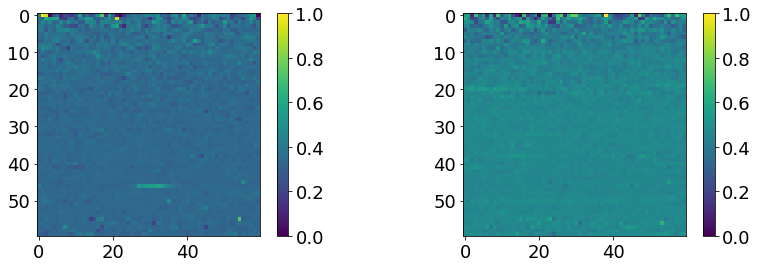

In [16]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(2, 2, 1)
im = ax.imshow(lens[33,:,:,0])
ax.autoscale(False)
cb = fig.colorbar(im, ax=ax)

ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
im = ax2.imshow(single[2,:,:,0])
ax2.autoscale(False)
cb = fig.colorbar(im, ax=ax2)

plt.show()

#### Plot Ivar

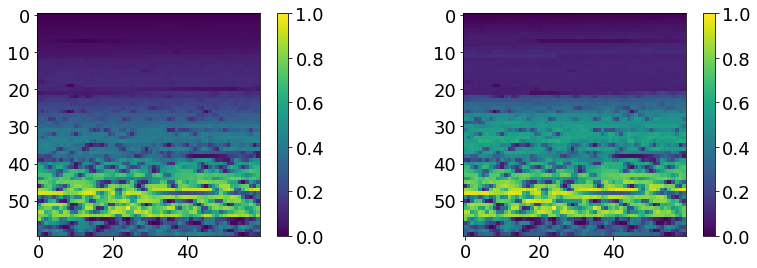

In [17]:
fig = plt.figure(figsize=(14,9))

ax = fig.add_subplot(2, 2, 1)
im = ax.imshow(lens[10,:,:,1])
ax.autoscale(False)
cb = fig.colorbar(im, ax=ax)

ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
im = ax2.imshow(single[25,:,:,1])
ax2.autoscale(False)
cb = fig.colorbar(im, ax=ax2)

plt.show()

## CNN Network Setup

Train network with TensorFlow+Keras.

In [18]:
#import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
def network(ncat, input_shape=(60,60,1), learning_rate=1.8225460564333567e-05, reg=0.05, dropout=0.5, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """

    # input flux and ivar
    visible_flux = Input((60,60,1), name='Input_Spec1')
    visible_ivar = Input((60,60,1), name='Input_Ivar1')
    
    # First Branch - Flux
    
    # first feature extractor
    conv1_flux = Conv2D(28, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X_flux = BatchNormalization(axis=2)(conv1_flux)
    pool1_flux = MaxPooling2D(pool_size=(3, 3))(X_flux)
    flat1_flux = Flatten()(pool1_flux)
    
     # second feature extractor
    conv2_flux = Conv2D(28, kernel_size=8, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X2_flux = BatchNormalization(axis=2)(conv2_flux)
    pool2_flux = MaxPooling2D(pool_size=(3, 3))(X2_flux)
    flat2_flux = Flatten()(conv2_flux)
    
     # third feature extractor
    conv3_flux = Conv2D(28, kernel_size=16, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X3_flux = BatchNormalization(axis=2)(conv3_flux)
    pool3_flux = MaxPooling2D(pool_size=(3, 3))(X3_flux)
    flat3_flux = Flatten()(pool3_flux)
    
     # Fourth feature extractor
    conv4_flux = Conv2D(28, kernel_size=32, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X4_flux = BatchNormalization(axis=2)(conv4_flux)
    pool4_flux = MaxPooling2D(pool_size=(3, 3))(X4_flux)
    flat4_flux = Flatten()(pool4_flux)
    
    # Fifth feature extractor
    conv5_flux = Conv2D(28, kernel_size=56, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X5_flux = BatchNormalization(axis=2)(conv4_flux)
    pool5_flux = MaxPooling2D(pool_size=(3, 3))(X5_flux)
    flat5_flux = Flatten()(pool5_flux)
    
    # REPEAT FOR IVAR BRANCH
    conv1_ivar = Conv2D(28, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_ivar)
    X_ivar = BatchNormalization(axis=2)(conv1_ivar)
    pool1_ivar = MaxPooling2D(pool_size=(3, 3))(X_ivar)
    flat1_ivar = Flatten()(pool1_ivar)
    
    conv2_ivar = Conv2D(28, kernel_size=8, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_ivar)
    X2_ivar = BatchNormalization(axis=2)(conv2_ivar)
    pool2_ivar = MaxPooling2D(pool_size=(3, 3))(X2_ivar)
    flat2_ivar = Flatten()(conv2_ivar)
    
    conv3_ivar = Conv2D(28, kernel_size=16, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_ivar)
    X3_ivar = BatchNormalization(axis=2)(conv3_ivar)
    pool3_ivar = MaxPooling2D(pool_size=(3, 3))(X3_ivar)
    flat3_ivar = Flatten()(pool3_ivar)
    
    # Fourth feature extractor
    conv4_ivar = Conv2D(28, kernel_size=32, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_ivar)
    X4_ivar = BatchNormalization(axis=2)(conv4_ivar)
    pool4_ivar = MaxPooling2D(pool_size=(3, 3))(X4_ivar)
    flat4_ivar = Flatten()(pool4_ivar)
    
    # Fifth feature extractor
    conv5_ivar = Conv2D(28, kernel_size=56, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_ivar)
    X5_ivar = BatchNormalization(axis=2)(conv4_ivar)
    pool5_ivar = MaxPooling2D(pool_size=(3, 3))(X5_ivar)
    flat5_ivar = Flatten()(pool5_ivar)
    
   # merge feature extractors for flux and ivar
    merge_flux = concatenate([flat1_flux,flat2_flux,flat3_flux,flat4_flux,flat5_flux])
    merge_ivar= concatenate([flat1_ivar,flat2_ivar,flat3_ivar,flat4_ivar,flat5_ivar])
    
    # combined outputs
    combined = concatenate([merge_flux, merge_ivar])
    
    # interpretation layer
    hidden1 = Dense(128, activation='relu')(combined)
    droput=Dropout(rate=dropout, seed=seed)(hidden1)
#     z = Dense(4, activation="relu")(combined)
#     z = Dense(2, activation="softmax")(z)

    # prediction output # softmax
    output = Dense(2, activation='softmax')(droput)
    
    final_model = Model(inputs=[visible_flux, visible_ivar], outputs=output)
    final_model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return final_model

In [20]:
model = network(ncat=y.shape[1])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Spec1 (InputLayer)        [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
Input_Ivar1 (InputLayer)        [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 57, 57, 28)   476         Input_Spec1[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 45, 45, 28)   7196        Input_Spec1[0][0]                
______________________________________________________________________________________________

## Train and Test

Split the data into training and testing (+ validation) samples and fit the network weights.

In [22]:
from sklearn.model_selection import train_test_split

def train_test_validate(x, y, train_size=0.75, test_size=0.125, val_size=0.125):
    # Ensure proper normalization.
    if train_size + test_size + val_size != 1:
        norm = train_size + test_size + val_size
        train_size = train_size/norm
        test_size = test_size/norm
        val_size = val_size/norm
        print('Renormalized to train {:g}, test {:g}, and validate {:g}'.format(train_size, test_size, val_size))
        
    # Split into training and testing samples.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size)
    
    # Split off the validation sample from the test sample.
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size+val_size))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [23]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validate(x, y, 0.6, 0.2, 0.2)

In [24]:
flux=x_train[:,:,:,0]
ivar=x_train[:,:,:,1]
flux_test=x_test[:,:,:,0]
ivar_test=x_test[:,:,:,1]

In [25]:
hist= model.fit(
    x=[flux, ivar], y=y_train,
    validation_data=([flux_test, ivar_test], y_test),
    epochs=100, batch_size=50, callbacks=[es], shuffle=True)

Epoch 1/100
208/208 [==============================] - 122s 585ms/step - loss: 1.3632 - accuracy: 0.6430 - val_loss: 1.3370 - val_accuracy: 0.7286
Epoch 2/100
208/208 [==============================] - 120s 576ms/step - loss: 1.2430 - accuracy: 0.6731 - val_loss: 1.2070 - val_accuracy: 0.6526
Epoch 3/100
208/208 [==============================] - 119s 572ms/step - loss: 1.1347 - accuracy: 0.7430 - val_loss: 1.0819 - val_accuracy: 0.7991
Epoch 4/100
208/208 [==============================] - 121s 581ms/step - loss: 1.0528 - accuracy: 0.7670 - val_loss: 1.0209 - val_accuracy: 0.7488
Epoch 5/100
208/208 [==============================] - 119s 573ms/step - loss: 0.9789 - accuracy: 0.7909 - val_loss: 0.9333 - val_accuracy: 0.8107
Epoch 6/100
208/208 [==============================] - 121s 580ms/step - loss: 0.9208 - accuracy: 0.8106 - val_loss: 0.8679 - val_accuracy: 0.8457
Epoch 7/100
208/208 [==============================] - 120s 579ms/step - loss: 0.8743 - accuracy: 0.8173 - val_loss: 0

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

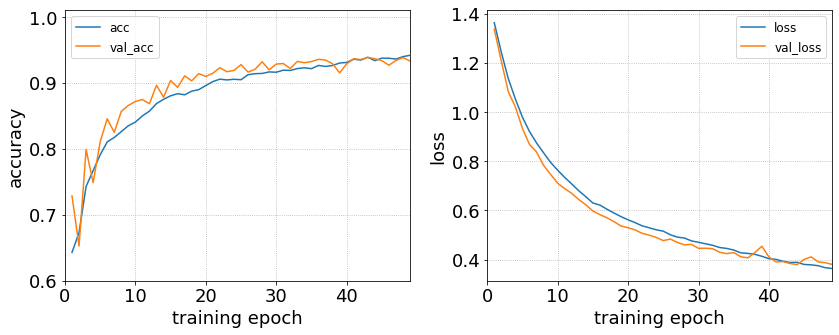

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.6,1.01)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('2label_acc_loss_ivar50.png', dpi=120)

### ROC Curve and Precision-Recall

Plot both the ROC curves per class and the class-averaged ROC curve.

In [27]:
flux=x_val[:,:,:,0]
ivar= x_val[:,:,:,1]
both=flux, ivar
y_pred = model.predict(both)

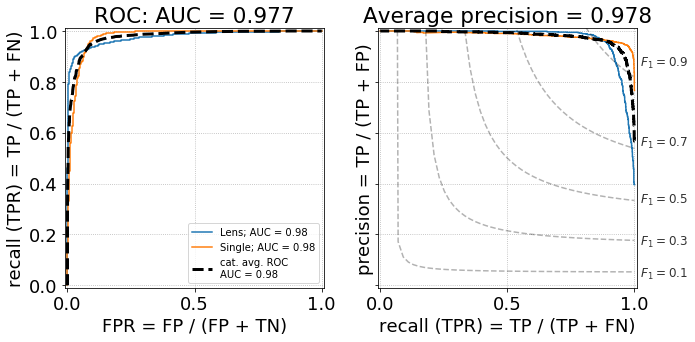

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val, y_pred)),
       aspect='equal')

fig.tight_layout()
fig.savefig('2label_roc_pr5_fluxivar.png', dpi=120)

### Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

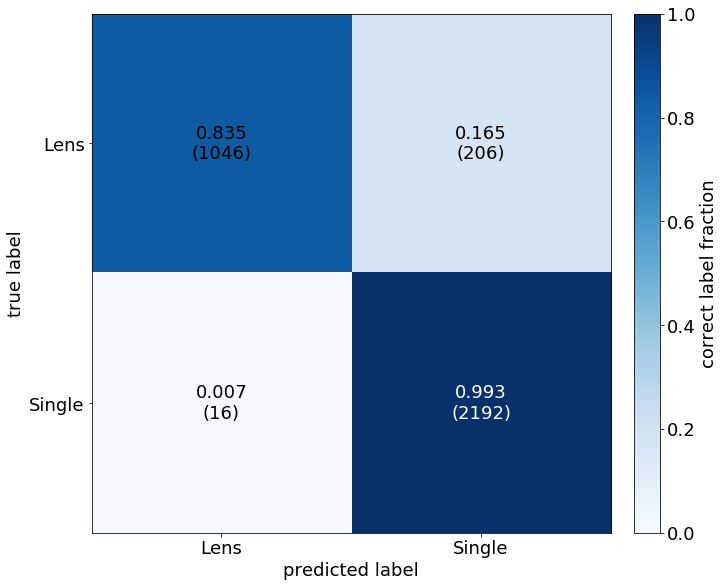

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('2label_cm_5_fluxivar_nocut.png', dpi=120)

In [31]:
model.save('fluxandivar_model')
# synthlens_fluxandivar_model -- uses flux and ivar but weird tile situation
#synthlensreduced_model --- more balanced sample of single and lens 
#synthlensfull_model ---was all data and 100 epochs
#synthlen_smodel ---- 40 percent of data 100 epochs
#synthlens_model ----original with 50 epochs

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: fluxandivar_model/assets


In [32]:
model.save('fluxandivar_model.h5')

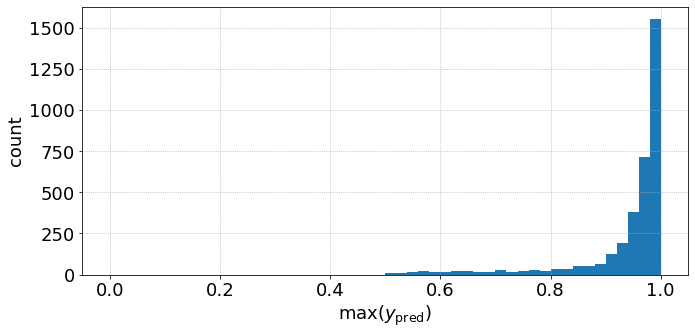

In [33]:
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig('max_ypred.png', dpi=120)

In [34]:
np.sum(y_max > 0.95) / len(y_max)

0.719364161849711

In [35]:
select = y_max > 0.995

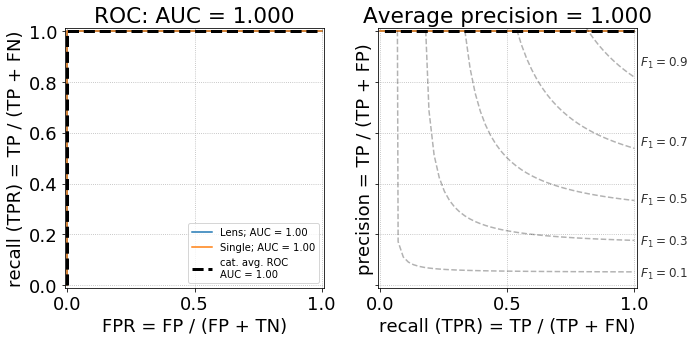

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[select][:,i], y_pred[select][:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[select][:,i], y_pred[select][:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[select].ravel(), y_pred[select].ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val[select], y_pred[select])),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr_y99_5.png', dpi=120)

In [37]:
# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val[select].argmax(axis=1), y_pred[select].argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

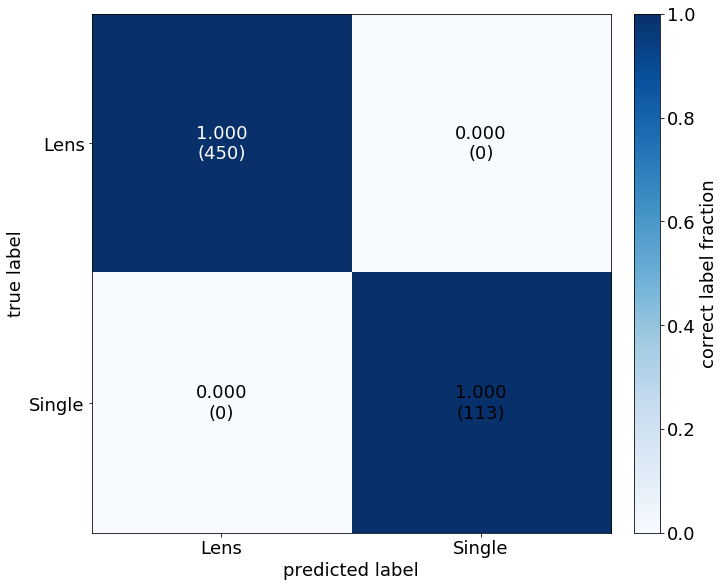

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

# thresh = 0.5*cm.max()
thresh = np.average(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm_ygt0.99_5.png', dpi=120)

In [39]:
len(y_pred), len(y_pred) - np.sum(select)

(3460, 2897)

In [42]:
# import tensorflow
# from tensorflow import keras
# model = tensorflow.keras.models.load_model('fluxandivar_model.h5')

In [45]:
import pickle 
import numpy as np

with open('too_20210708.data', 'rb') as filehandle:
    too_data = pickle.load(filehandle)
with open('too_20210708_ivar.data', 'rb') as filehandle:
    too_data_ivar = pickle.load(filehandle)

In [46]:
too_flux=np.asarray(too_data)
too_ivar=np.asarray(too_data_ivar)
too=np.stack((too_flux, too_ivar), axis=-1)
too.shape
too_both=too_flux, too_ivar

#### Run the TensorFlow Model on the Data

In [47]:
y_pred = model.predict(too_both)

Get the Prediction

The `argmax` function will return which label gets the highest probability. We'll choose this as the correct label. The labels should correspond to:
* 0: strong lens candidate
* 1: single galaxy

In [55]:
y_max = np.max(y_pred, axis=1)
select = y_max  > 0.99
labels=(y_pred[select][:]).argmax(axis=1)

(array([  0.,   0.,   0.,   0.,   0., 529.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

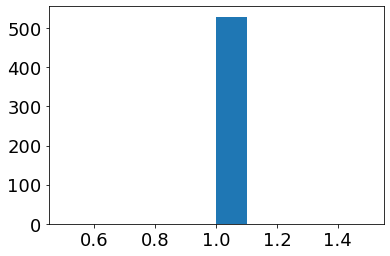

In [56]:
#labels = y_pred[select].argmax(axis=1)
plt.hist(labels)

In [57]:
def countOf(labels, x):
    count = 0
    for element in labels:
        if (element == x):
            count = count + 1
    return count

In [58]:
countOf(labels,0)

0

In [59]:
countOf(labels,1)

529

#### Simple Check: Simulated Data

In [60]:
one=single[:,:,:,0]
two=single[:,:,:,1]
both=[one,two]
y_pred = model.predict(both)

In [61]:
y_max = np.max(y_pred, axis=1)

In [62]:
select = y_max > 0.95

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 8.625e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

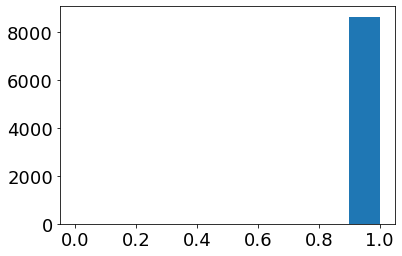

In [63]:
labels=(y_pred[select][:]).argmax(axis=1)
plt.hist(labels)

In [64]:
countOf(labels,0)

1

In [65]:
countOf(labels,1)

8625

In [66]:
one=lens[:,:,:,0]
two=lens[:,:,:,1]
both=[one,two]
y_pred = model.predict(both)

In [67]:
y_max = np.max(y_pred, axis=1)
select = y_max > 0.99
labels=(y_pred[select][:]).argmax(axis=1)

(array([2786.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           7.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

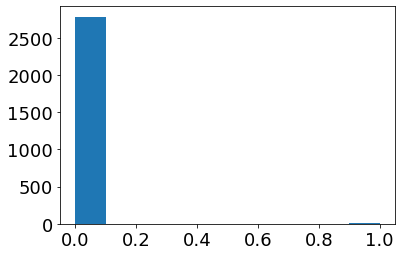

In [68]:
#labels = y_pred.argmax(axis=1)
plt.hist(labels)

In [69]:
countOf(labels,0)

2786

In [70]:
countOf(labels,1)

7

## Check based on alpha 

In [71]:
with open('lens_spectra_equal_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    equal_flux = pickle.load(filehandle)
with open('ivar_lens_spectra_equal_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    equal_ivar = pickle.load(filehandle)
with open('lens_spectra_less_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    less_flux = pickle.load(filehandle)
with open('ivar_lens_spectra_less_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    less_ivar = pickle.load(filehandle)
with open('lens_spectra_very_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    very_flux = pickle.load(filehandle)
with open('ivar_lens_spectra_very_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    very_ivar = pickle.load(filehandle)
with open('lens_spectra_extr_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    extr_flux = pickle.load(filehandle)
with open('ivar_lens_spectra_extr_alpha.data', 'rb') as filehandle:
    # read the data as binary data stream
    extr_ivar = pickle.load(filehandle)

In [72]:
# Change these based on which you want to look at
equal_flux=np.asarray(equal_flux)
equal_ivar=np.asarray(equal_ivar)
equal_lens=np.stack((equal_flux, equal_ivar), axis=-1)

(array([415.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

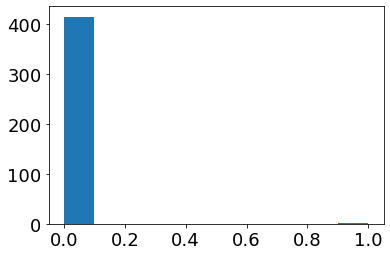

In [73]:
# equal with
one=equal_lens[:,:,:,0]
two=equal_lens[:,:,:,1]
both=[one,two]
y_pred = model.predict(both)
y_max = np.max(y_pred, axis=1)
np.sum(y_max > 0.95) / len(y_max)
select = y_max > 0.99
labels=(y_pred[select][:]).argmax(axis=1)
plt.hist(labels)